# VSC result analysis

In [1]:
import glob
import io
import os
import sys
import itertools
import collections
from typing import List

import pandas as pd
import numpy as np
import tqdm  #.notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib.text import Text
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
sys.path.append("..")

In [3]:
from vsc.metrics import (
    Match as Match1, match_metric, CandidatePair, average_precision,
    MatchingTrackMetrics, format_video_id, Dataset,
)

In [4]:
class Match(Match1):

    @classmethod
    def from_df(
        cls, df, is_gt=False, check=True
    ) -> List["Match"]:
        df = df.copy()
        df["query_id"] = df.query_id.map(lambda x: format_video_id(x, Dataset.QUERIES))
        df["ref_id"] = df.ref_id.map(lambda x: format_video_id(x, Dataset.REFS))
        if is_gt:
            df["score"] = 1.0
        df = df[list(cls._fields)]
        if check:
            for field in cls._fields:
                assert not df[field].isna().any()
        return [Match(**record) for record in df.to_dict("records")]


def inline_table(tsv_str):
    return pd.read_csv(io.StringIO(tsv_str), sep="\t")

In [5]:
DATA_PATH = "../data"
OUTPUT_PATH = f"{DATA_PATH}/plots"

In [6]:
if os.path.exists(DATA_PATH):
    os.makedirs(OUTPUT_PATH, exist_ok=True)

In [427]:
def save_fig(name):
    for ext in ["pdf", "png"]:
        plt.savefig(f"{OUTPUT_PATH}/{name}.{ext}", bbox_inches="tight")

## Read ground truth with transform data

In [7]:
gt_df = pd.read_csv(f"{DATA_PATH}/vsc_test_gt_xforms.csv")
gt_df["transforms"] = gt_df.transform_name.map(lambda x: x.replace("_", " ").split("  "))
# del gt_df["transform_name"]

In [10]:
all_transforms = set()
for xforms in gt_df.transforms.values:
    all_transforms.update(xforms)
all_transforms = sorted(all_transforms)

In [11]:
len(all_transforms)

27

In [47]:
# skipping rows we want to hide: time crop, insert in background
xform_meta = inline_table("""
transform	name	type
add noise	noise	frame
blend videos	blend videos	multi-frame
blur	blur	frame
brightness	brightness	frame
change aspect ratio	change aspect ratio	frame
change video speed	change video speed	temporal
color jitter	color jitter	frame
crop	crop	frame
encoding quality	encoding quality	frame
grayscale	grayscale	frame
hflip	flip	frame
hstack	hstack	multi-frame
insert in background multiple	multiple copies	temporal
overlay emoji	overlay emoji	frame
overlay onto screenshot	screenshot	frame
overlay pandas	frame effect	frame
overlay text	overlay text	frame
pad	pad	frame
perspective transform and shake	perspective transform	frame
pixelization	pixelization	frame
rooms	rooms	multi-frame
rotate	rotate	frame
scale	rescale	frame
time decimate	time decimate	temporal
vstack	vstack	multi-frame
""")

In [48]:
count_df = pd.DataFrame(
    collections.Counter(itertools.chain(*gt_df.transforms.values)).items(),
    columns=["transform", "count"],
).sort_values("count", ascending=False).reset_index(drop=True)

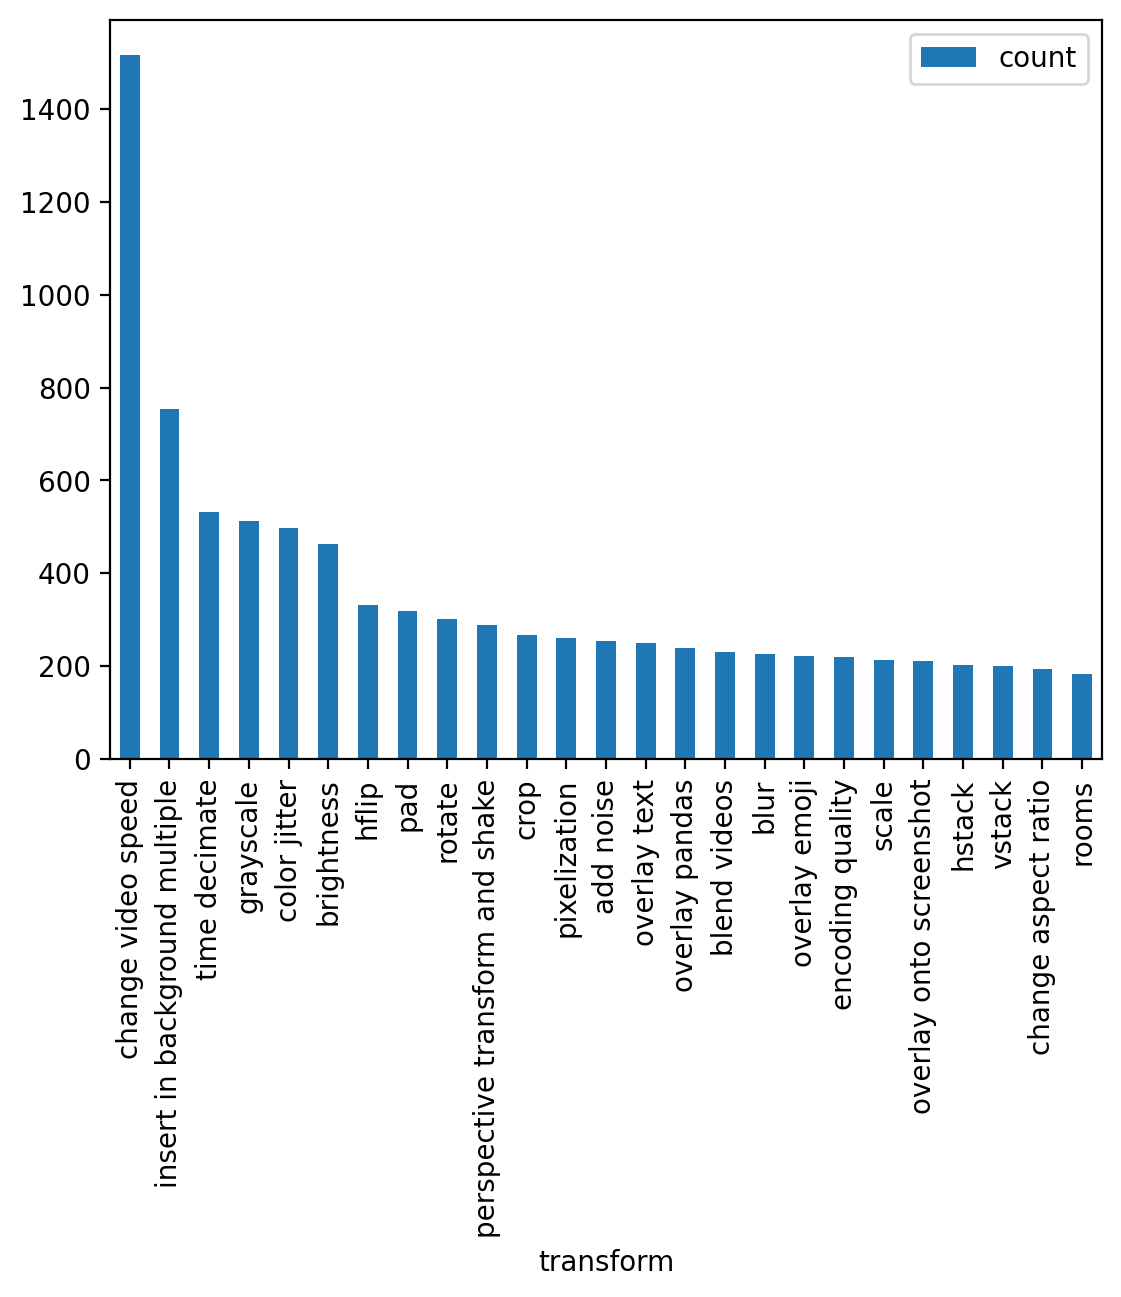

In [215]:
df2 = df.set_index("transform")[["name", "count"]]
ax = df2.plot.bar()
plt.savefig(OUTPUT_PATH + '/transform_freq.pdf', bbox_inches="tight")

## Read top submissions

In [269]:
# glob.glob(f"{DATA_PATH}/predictions/matching/*.csv"), glob.glob(f"{DATA_PATH}/predictions/descriptor/*.csv")

In [287]:
matching_full = [pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/predictions/matching/*.csv")]
matching_full_baseline = matching_full + [pd.read_csv(f"{DATA_PATH}/predictions/baseline-matching.csv")]

In [57]:
# One participant has 50MB of predictions, which makes analysis slow, and makes a 0.005 difference
matching = [x.sort_values("score", ascending=False).iloc[:100000, :] for x in matching_full]

In [291]:
descriptors_full = [pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/predictions/descriptor/*.csv")]
descriptors_full_baseline = descriptors_full + [pd.read_csv(f"{DATA_PATH}/predictions/baseline-descriptor.csv")]

In [59]:
# Truncating to 20k rows has 0.1% error, and is much faster
descriptors = [x.sort_values("score", ascending=False).iloc[:20000, :] for x in descriptors_full]

In [245]:
def query_ids_by_xform(gt_df, transform):
    df = gt_df[gt_df.transforms.map(lambda x: transform in x)]
    queries = set(df.query_id.values)
    return queries


def only_queries(df, queries, all_gt_queries):
    # return rows with included GT queries, plus rows for non-GT (distractor) queries
    return df[(df.query_id.isin(queries) == True) | (df.query_id.isin(all_gt_queries) == False)]


def exclude_queries(df, queries, all_gt_queries):
    return df[df.query_id.isin(queries) == False]

In [274]:
def matching_metric_for_queries(query_ids, gt_df, predictions, exclude=False, progress=False, descriptor=False, **kwargs):
    all_gt_queries = set(gt_df.query_id.values)
    filter_fn = exclude_queries if exclude else only_queries
    gt_df = filter_fn(gt_df, query_ids, all_gt_queries)
    gt = Match.from_df(gt_df, is_gt=True)
    if descriptor:
        gt = CandidatePair.from_matches(gt)
    metrics = []
    if progress:
        predictions = tqdm.tqdm(predictions)
    for pred_df in predictions:
        pred_df = filter_fn(pred_df, query_ids, all_gt_queries)
        if descriptor:
            pairs = CandidatePair.from_df(pred_df)
            metric = average_precision(gt, pairs).ap
        else:
            pred = Match.from_df(pred_df, is_gt=False)
            metric = match_metric(gt, pred).ap
        metrics.append(metric)
    track = "descriptor" if descriptor else "matching"
    return dict(
        mean_metric=np.mean(metrics), metrics=metrics, track=track,
        exclude=exclude, gt_rows=len(gt_df), **kwargs
    )


def matching_metric_for_transform(transform, gt_df, predictions, **kwargs):
    query_ids = query_ids_by_xform(gt_df, transform)
    return matching_metric_for_queries(query_ids, gt_df, predictions, transform=transform, **kwargs)


def matching_metric_without_distractors(gt_df, predictions, exclude=True, **kwargs):
    assert exclude
    all_gt_queries = set(gt_df.query_id.values)
    all_queries = set()
    for preds in predictions:
        all_queries.update(preds.query_id.values)
    distractor_queries = all_queries - all_gt_queries
    return matching_metric_for_queries(distractor_queries, gt_df, predictions, exclude=True, **kwargs)


def simple_eval(gt_df, predictions, descriptor=False, progress=False):
    gt = Match.from_df(gt_df, is_gt=True)
    if descriptor:
        gt = CandidatePair.from_matches(gt)
    if progress:
        predictions = tqdm.tqdm(predictions)
    metrics = []
    for pred_df in predictions:
        if descriptor:
            pairs = CandidatePair.from_df(pred_df)
            metrics.append(average_precision(gt, pairs))
        else:
            pred = Match.from_df(pred_df, is_gt=False)
            metrics.append(match_metric(gt, pred))
    return metrics

In [288]:
# Competition metrics
matching_track_aps = simple_eval(gt_df, matching_full_baseline)
[x.ap for x in matching_track_aps]

[0.9153252703101736,
 0.7036088302525891,
 0.7710875548719611,
 0.44114441608969657]

In [292]:
descriptor_track_aps = simple_eval(gt_df, descriptors_full_baseline, descriptor=True)
[x.ap for x in descriptor_track_aps]

[0.8717103155601373,
 0.8362334593195941,
 0.8514212472813107,
 0.6047489199210752]

In [25]:
# Reproduce competition metrics, as a test.
matching_metric_for_transform("not-a-real-xform", gt_df, matching_full, exclude=True)["metrics"]

[0.9153252703101736, 0.7036088302525891, 0.7710875548719611]

In [26]:
# Limiting CVL to 100k predictions, slightly worse metrics
matching_metric_for_transform("not-a-real-xform", gt_df, matching, exclude=True)["metrics"]

[0.9153252703101736, 0.6987100385364761, 0.7710875548719607]

In [17]:
# Reproduce descriptor metrics
matching_metric_for_transform("not-a-real-xform", gt_df, descriptors_full, descriptor=True, exclude=True)["metrics"]

[0.8717103155601373, 0.8362334593195941, 0.8514212472813107]

In [53]:
# truncated
matching_metric_for_transform("not-a-real-xform", gt_df, descriptors, descriptor=True, exclude=True)["metrics"]

[0.8715290560840903, 0.835456916905572, 0.8512026624563811]

In [253]:
# Without distractors
no_distractors_m = matching_metric_without_distractors(gt_df, matching_full)["metrics"]
no_distractors_m

[0.9186818533950416, 0.7938465952372309, 0.7966208301577202]

In [257]:
no_distractors_d = matching_metric_without_distractors(gt_df, descriptors_full, descriptor=True)["metrics"]
no_distractors_d

[0.8821096623733202, 0.8938526055244386, 0.9005291063701039]

In [262]:
with_distractors_m = np.array([0.9153252703101736, 0.7036088302525891, 0.7710875548719611])
no_distractors_m = np.array(no_distractors_m)
with_distractors_d = np.array([0.8717103155601373, 0.8362334593195941, 0.8514212472813107])
no_distractors_d = np.array(no_distractors_d)

In [263]:
no_distractors_m - with_distractors_m, no_distractors_d - with_distractors_d

(array([0.00335658, 0.09023776, 0.02553328]),
 array([0.01039935, 0.05761915, 0.04910786]))

In [264]:
(no_distractors_m - with_distractors_m).mean(), (no_distractors_d - with_distractors_d).mean()

(0.03970920778508961, 0.039042117368940144)

In [259]:
np.mean([0.8717103155601373, 0.8362334593195941, 0.8514212472813107]), np.mean(no_distractors_d)

(0.8531216740536808, 0.8921637914226209)

In [63]:
def analyze_transforms(transforms, gt_df, matching, exclude=False, descriptor=False, **kwargs):
    records = []
    for transform in tqdm.tqdm(transforms):
        records.append(matching_metric_for_transform(transform, gt_df, matching, descriptor=descriptor, exclude=exclude, **kwargs))
    df = pd.DataFrame(records)
    df = df.sort_values("mean_metric", ascending=not exclude)
    metric_name = "descriptor track uAP" if descriptor else "matching track metric"
    df = df.rename(columns=dict(mean_metric=metric_name))
    return df

In [65]:
adf = analyze_transforms(all_transforms, gt_df, matching_full) # matching)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [22:18<00:00, 49.56s/it]


In [66]:
adf_d = analyze_transforms(all_transforms, gt_df, descriptors_full, descriptor=True)  # descriptors

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [15:05<00:00, 33.55s/it]


In [182]:
df = adf.copy().set_index("transform")[["matching track metric"]]
df2 = adf_d.copy().set_index("transform")[["descriptor track uAP"]]
by_transform_df = df2.join(df).join(
    xform_meta.set_index("transform"), on="transform", how="inner"
).rename(columns={
    "name": "transform",
    "matching track metric": "VCL track",
    "descriptor track uAP": "VCD track"
}).set_index("transform")

In [210]:
by_transform_df.to_csv(OUTPUT_PATH + '/transform_metrics.csv')

In [155]:
sns.color_palette("hls", 2)

[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.8287999999999999, 0.86)]

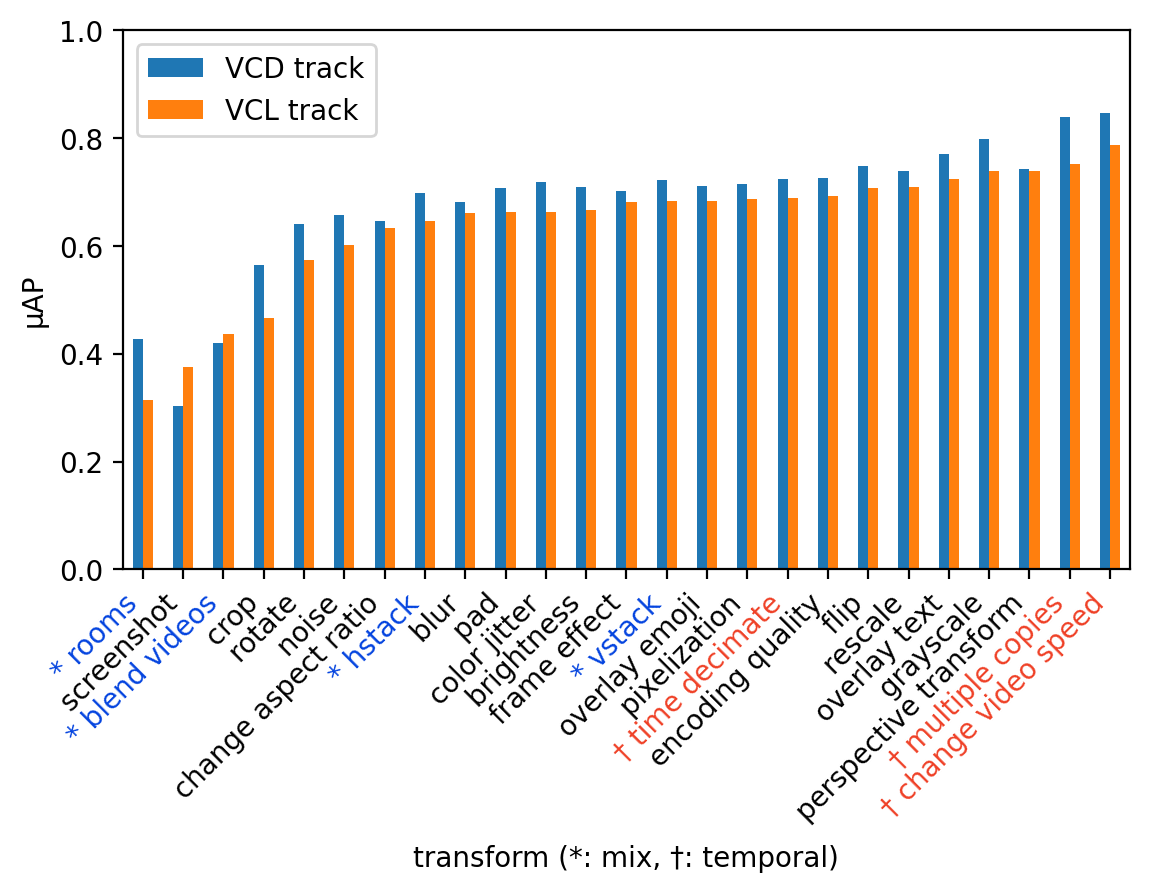

In [480]:
pal = sns.color_palette()
df = by_transform_df.copy()
#df["mean"] = by_transform_df["VCL track"].values * by_transform_df["VCD track"].values
#df = df.loc[df.sort_values("mean").index][["VCD track", "VCL track"]]
df = df.loc[df.sort_values("VCL track").index]

#fig, ax = plt.subplots(figsize=(10, 3.5))
fig, ax = plt.subplots(figsize=(6.5, 3.5))
#ax = None
ax = df.plot.bar(color=pal, ax=ax)
ax.set_ylim(0, 1)

types = dict(zip(xform_meta["name"], xform_meta["type"]))
type_color = {"multi-frame": "xkcd:blue", "frame": "black", "temporal": "xkcd:tomato"}
#type_suffix = {"multi-frame": "[m]", "frame": "[f]", "temporal": "[t]"}
type_prefix = {"multi-frame": "*", "frame": "", "temporal": "†"}
ticklabels = ax.get_xticklabels()
for label in ticklabels:
    xform = label.get_text()
    type_ = types[xform]
    label.set_color(type_color[type_])
    label.set_text(type_prefix[type_] + " " + xform)
    #label.set_text(f"{xform} {type_suffix[type_]}")

ax.set_xlabel("transform (*: mix, †: temporal)")
ax.set_ylabel("μAP")
ax.set_xticklabels(ticklabels, rotation=45, ha='right')
ax.legend(loc='upper left')
plt.savefig(OUTPUT_PATH + '/transform_metrics.pdf', bbox_inches="tight")
None

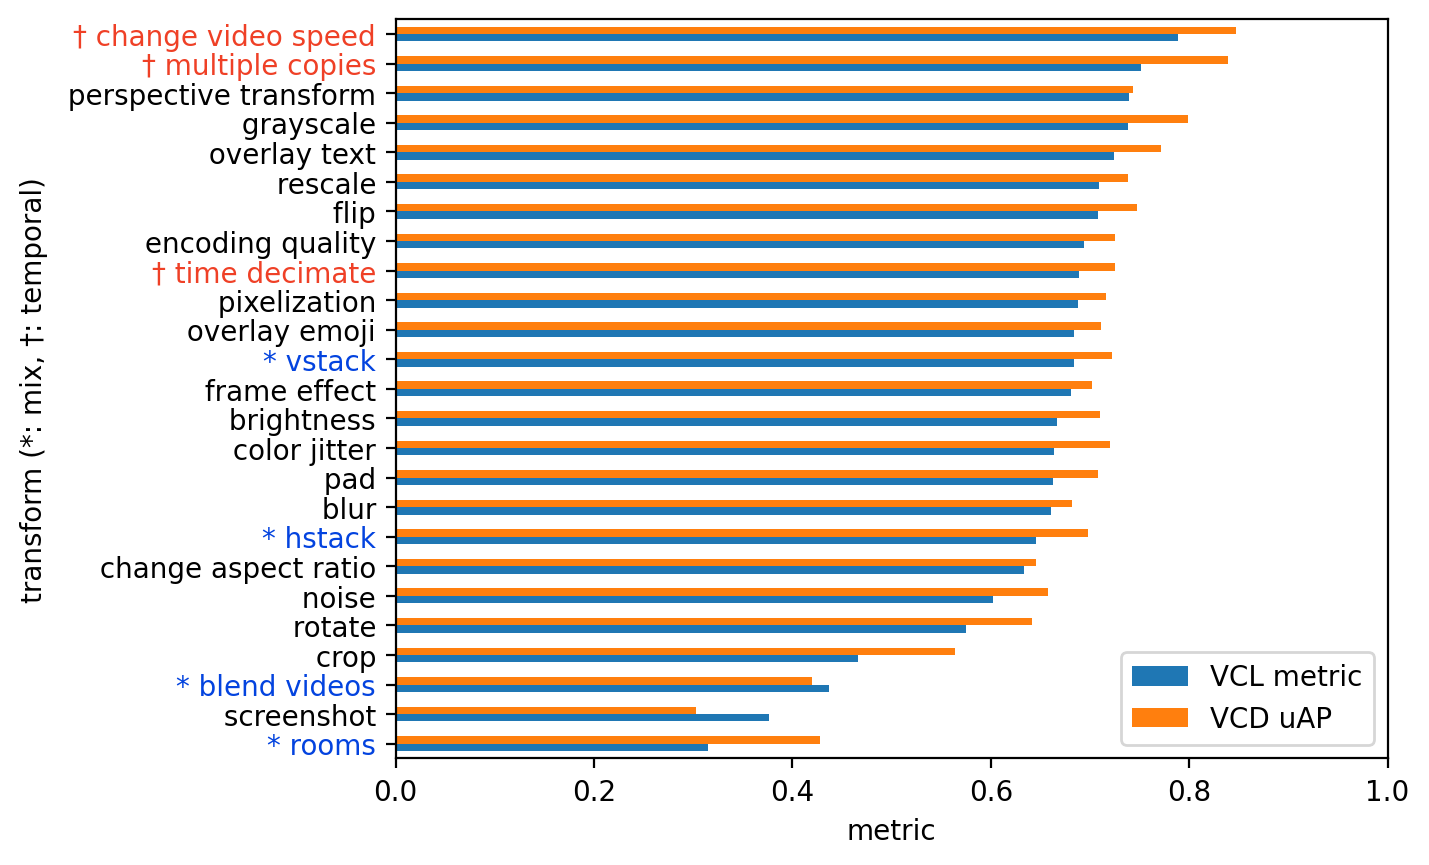

In [99]:
ax = by_transform_df.plot.barh()
ax.set_xlim(0, 1)

types = dict(zip(xform_meta["name"], xform_meta["type"]))
type_color = {"multi-frame": "xkcd:blue", "frame": "black", "temporal": "xkcd:tomato"}
#type_suffix = {"multi-frame": "[m]", "frame": "[f]", "temporal": "[t]"}
type_prefix = {"multi-frame": "*", "frame": "", "temporal": "†"}
ticklabels = ax.get_yticklabels()
for label in ticklabels:
    xform = label.get_text()
    type_ = types[xform]
    label.set_color(type_color[type_])
    label.set_text(type_prefix[type_] + " " + xform)
    #label.set_text(f"{xform} {type_suffix[type_]}")

ax.set_ylabel("transform (*: mix, †: temporal)")
ax.set_xlabel("μAP metric")
ax.set_yticklabels(ticklabels)#, rotation=45, ha='right')
ax.legend(loc='lower right')
plt.savefig(OUTPUT_PATH + '/transform_metrics_horiz.pdf', bbox_inches="tight")
None

In [125]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [114]:
df1 = by_transform_df.rename(columns={"VCD track": "uAP"})[["uAP"]].reset_index()
df1["track"] = "VCD track"
df2 = by_transform_df.rename(columns={"VCL track": "uAP"})[["uAP"]].reset_index()
df2["track"] = "VCL track"
combined_df = pd.concat([df1, df2])

<AxesSubplot: xlabel='transform', ylabel='uAP'>

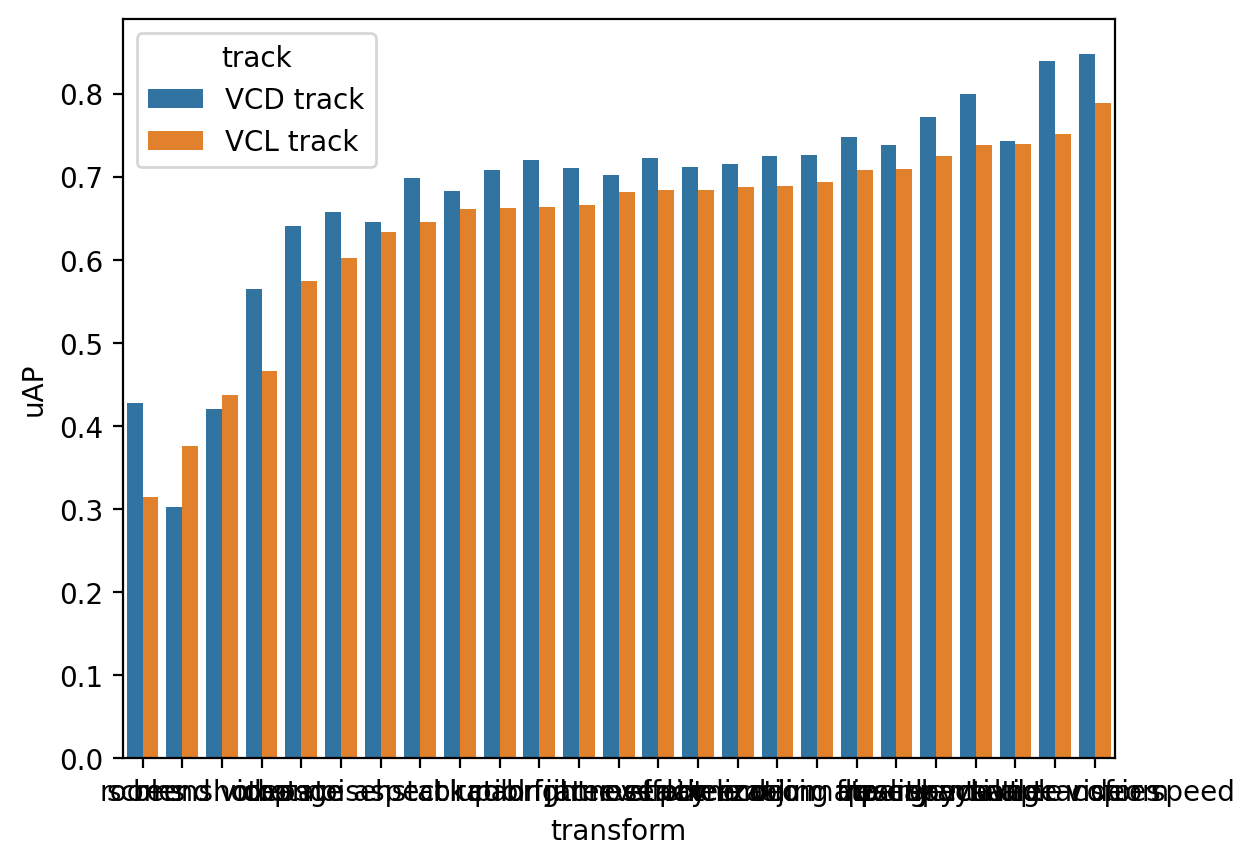

In [118]:
sns.barplot(data=combined_df, x="transform", y="uAP", hue="track") #, "VCL track"])

In [ ]:
# leave one out
adf_loo = analyze_transforms(all_transforms, exclude=True)

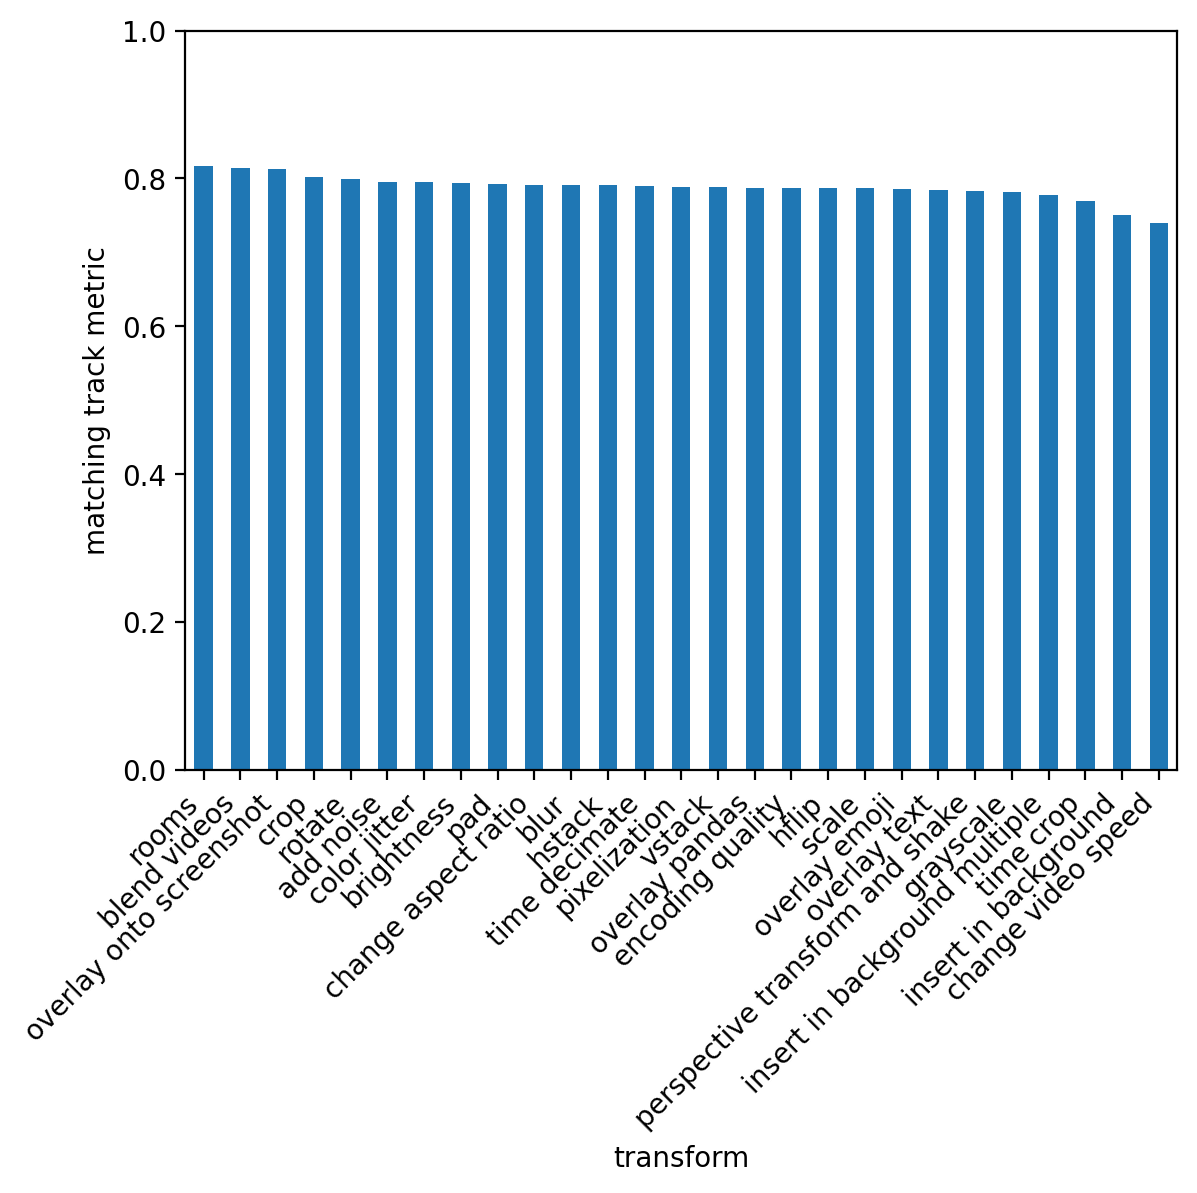

In [243]:
ax = adf_loo.plot.bar(x="transform", y="matching track metric", legend=False)
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("matching track metric")
None

In [172]:
nontrivial_xforms = set(xform_meta["transform"].values)
nontrivial_xforms.remove("insert in background multiple")  # not really a transform
len(nontrivial_xforms)

24

In [187]:
def query_ids_by_num_xforms(gt_df):
    df = gt_df.copy()
    df["num_xforms"] = gt_df.transforms.map(
        lambda x: len([y for y in x if y in nontrivial_xforms])
    )
    return {
        i: set(df[df.num_xforms == i].query_id.values)
        for i in sorted(set(df.num_xforms.values))
    }


query_ids_by_n_xforms = query_ids_by_num_xforms(gt_df)

In [188]:
by_num_xforms = pd.DataFrame([
    matching_metric_for_queries(query_ids, gt_df, matching_full, exclude=False, num_transforms=i)
    for (i, query_ids) in query_ids_by_n_xforms.items()
])

In [189]:
by_num_xforms_desc = pd.DataFrame([
    matching_metric_for_queries(query_ids, gt_df, descriptors_full, exclude=False, num_transforms=i, descriptor=True)
    for (i, query_ids) in query_ids_by_n_xforms.items()
])

{2: 504, 3: 601, 4: 631, 5: 104}

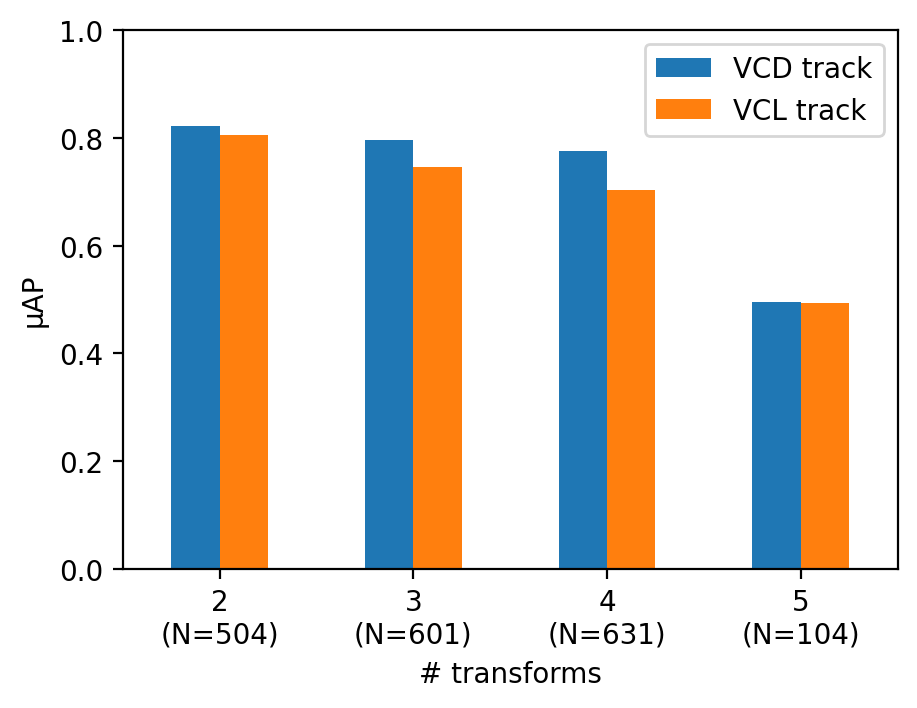

In [477]:
df = by_num_xforms.rename(
    columns=dict(mean_metric="VCL track", num_transforms="num transforms")
).set_index("num transforms")[["VCL track"]]
df2 = by_num_xforms_desc.rename(
    columns=dict(mean_metric="VCD track", num_transforms="num transforms")
).set_index("num transforms")[["VCD track"]]
by_num_xforms_df = df2.join(df)
transform_counts = {k: len(v) for (k, v) in query_ids_by_n_xforms.items()}
fig, ax = plt.subplots(figsize=(5, 3.5))
ax = by_num_xforms_df.plot.bar(color=pal, ax=ax)
ax.set_ylim(0, 1)
labels = ax.get_xticklabels()
for l in labels:
    num = int(l.get_text())
    count = transform_counts[num]
    l.set_text(f"{num}\n(N={count})")
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_ylabel("μAP")
ax.set_xlabel("# transforms")
plt.savefig(OUTPUT_PATH + '/num_transforms_metrics.pdf')

In [470]:
labels[0].get_text()

'a'

In [191]:
by_num_xforms_df.to_csv(OUTPUT_PATH + '/num_transforms_metrics.csv')

Why are 5 xforms so much harder?

In [240]:
df = gt_df.copy()
df["transforms"] = df.transforms.map(
    lambda x: [y for y in x if y in nontrivial_xforms]
)
df["num_xforms"] = df.transforms.map(len)

In [244]:
c = collections.Counter(df.num_xforms.values)
df8 = pd.DataFrame([dict(num_xforms=k, num_queries=v) for (k, v) in sorted(c.items())])
df8["fraction"] = df8.num_queries / len(df)
df8

,num_xforms,num_queries,fraction
0,2,643,0.255260
1,3,845,0.335451
2,4,840,0.333466
3,5,191,0.075824


In [229]:
df5 = df[df.num_xforms == 4]
df2 = pd.DataFrame(
    collections.Counter(itertools.chain(*df5.transforms.values)).items(),
    columns=["transform", "count"],
).sort_values("count", ascending=False).reset_index(drop=True)
df2["fraction"] = df2["count"] / len(df5)
df2

,transform,count,fraction
0,change video speed,639,0.760714
1,grayscale,213,0.253571
2,brightness,210,0.250000
3,color jitter,208,0.247619
4,pad,144,0.171429
5,rotate,135,0.160714
6,time decimate,128,0.152381
7,hflip,126,0.150000
8,overlay text,126,0.150000
9,perspective transform and shake,125,0.148810


In [230]:
df3 = df[df.num_xforms == 5]
df4 = pd.DataFrame(
    collections.Counter(itertools.chain(*df3.transforms.values)).items(),
    columns=["transform", "count"],
).sort_values("count", ascending=False).reset_index(drop=True)
df4["fraction"] = df4["count"] / len(df3)
df4

,transform,count,fraction
0,time decimate,191,1.000000
1,change video speed,139,0.727749
2,grayscale,61,0.319372
3,color jitter,56,0.293194
4,brightness,43,0.225131
5,crop,39,0.204188
6,hflip,38,0.198953
7,rotate,37,0.193717
8,change aspect ratio,36,0.188482
9,vstack,31,0.162304


In [237]:
df45 = df4.set_index("transform").join(df2.set_index("transform"), lsuffix="_t5", rsuffix="_t4")
df45["ratio"] = df45.fraction_t5 / df45.fraction_t4
df45.sort_values("ratio")

,count_t5,fraction_t5,count_t4,fraction_t4,ratio
transform,,,,,
overlay text,13,0.068063,126,0.150000,0.453752
perspective transform and shake,18,0.094241,125,0.148810,0.633298
blend videos,13,0.068063,86,0.102381,0.664800
hstack,15,0.078534,97,0.115476,0.680089
pad,23,0.120419,144,0.171429,0.702443
add noise,20,0.104712,113,0.134524,0.778390
scale,18,0.094241,100,0.119048,0.791623
brightness,43,0.225131,210,0.250000,0.900524
encoding quality,24,0.125654,112,0.133333,0.942408


(191, 840)

In [284]:
set(df[df.num_xforms == 3].transforms.map(lambda x: x[0]).values)

{'insert in background multiple'}

In [289]:
# df[df.num_xforms == 6].transform_name.values

In [87]:
import sklearn.metrics

In [90]:
#sklearn.metrics.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)
sklearn.metrics.average_precision_score(
    [1, 0], [2, 1]
)

1.0

In [416]:
def plot_pr(ap, name, **kwargs):
    label = f"{name} ({ap.ap * 100:2.1f})"
    ax = ap.pr_curve.plot(label=label, **kwargs)
    ax.set_xlim(0, 1.02)
    ax.set_ylim(0, 1.02)
    ax.set_ylabel("precision")
    ax.set_xlabel("recall")

In [417]:
team_names = ["WeChat CV", "LINE CVL", "Friendship First", "baseline"]
team_order = [0, 2, 1, 3]
team_colors = list(sns.color_palette()[:3]) + ["gray"]

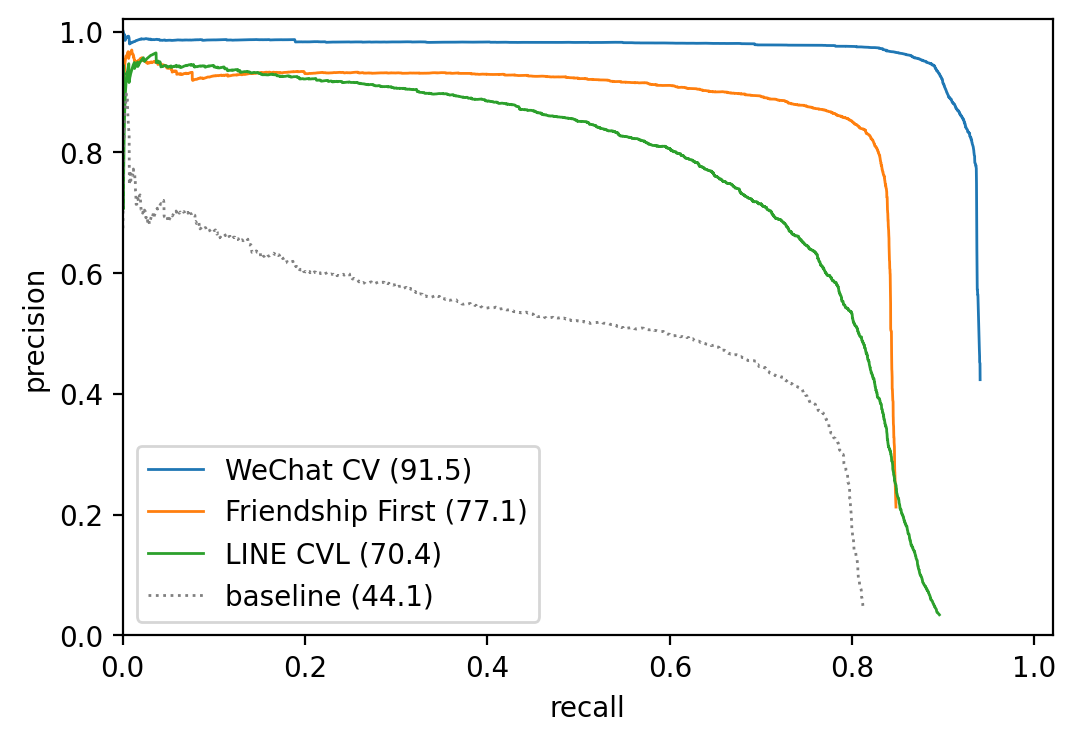

In [438]:
fig, ax = plt.subplots(figsize=(6, 4))
options = dict(linewidth=1)
plot_pr(matching_track_aps[0], "WeChat CV", **options, ax=ax)
plot_pr(matching_track_aps[2], "Friendship First", **options, ax=ax)
plot_pr(matching_track_aps[1], "LINE CVL", **options, ax=ax)
plot_pr(matching_track_aps[3], "baseline", **options, color="gray", linestyle=":", ax=ax)
ax.legend(loc="lower left")
save_fig("matching-pr")
None

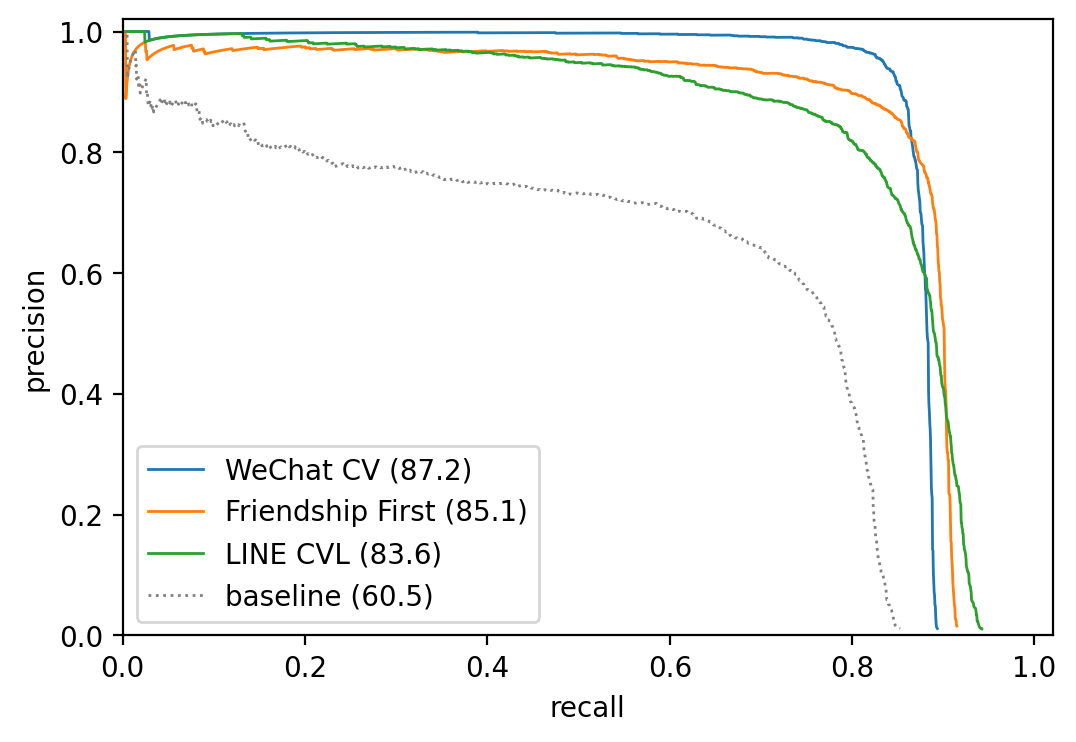

In [439]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_pr(descriptor_track_aps[0], "WeChat CV", **options, ax=ax)
plot_pr(descriptor_track_aps[2], "Friendship First", **options, ax=ax)
plot_pr(descriptor_track_aps[1], "LINE CVL", **options, ax=ax)
plot_pr(descriptor_track_aps[3], "baseline", **options, color="gray", linestyle=":", ax=ax)
ax.legend(loc="lower left")
save_fig("descriptor-pr")
None

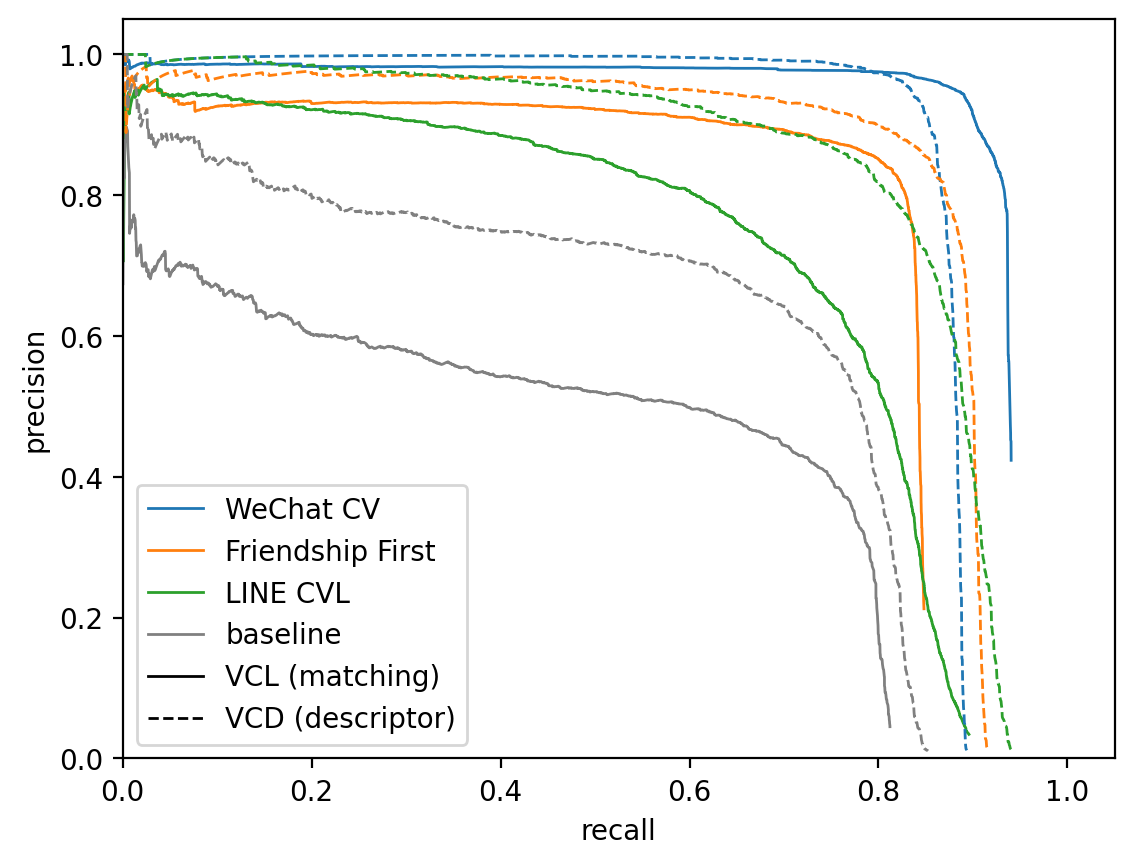

In [431]:
pal = sns.color_palette()
options = dict(linewidth=1)
ax = matching_track_aps[0].pr_curve.plot(label="WeChat CV", color=pal[0], **options)
ax = matching_track_aps[2].pr_curve.plot(label="Friendship First", color=pal[1], **options, ax=ax)
ax = matching_track_aps[1].pr_curve.plot(label="LINE CVL", color=pal[2], **options, ax=ax)
ax = matching_track_aps[3].pr_curve.plot(label="baseline", **options, color="gray", ax=ax)
ax.plot([], [], color="black", label="VCL (matching)", **options)
ax.plot([], [], color="black", linestyle="--", label="VCD (descriptor)", **options)
ax.legend(loc="lower left")
opts = dict(options)
opts["linestyle"] = "--"
ax = descriptor_track_aps[0].pr_curve.plot(label="WeChat CV", color=pal[0], **opts, ax=ax)
ax = descriptor_track_aps[2].pr_curve.plot(label="Friendship First", color=pal[1], **opts, ax=ax)
ax = descriptor_track_aps[1].pr_curve.plot(label="LINE CVL", color=pal[2], **opts, ax=ax)
ax = descriptor_track_aps[3].pr_curve.plot(label="baseline", **opts, color="gray", ax=ax)

save_fig("combined-pr")

In [279]:
glob.glob(f"{DATA_PATH}/predictions/matching/*.csv"), glob.glob(f"{DATA_PATH}/predictions/descriptor/*.csv")

(['../data/predictions/matching/do-something.csv',
  '../data/predictions/matching/cvl.csv',
  '../data/predictions/matching/friendship-first.csv'],
 ['../data/predictions/descriptor/do-something.csv',
  '../data/predictions/descriptor/cvl.csv',
  '../data/predictions/descriptor/friendship-first.csv'])

In [380]:
def simple_ap(correct, total):
    cumulative_correct = np.cumsum(correct)
    cumulative_predicted = np.arange(len(correct)) + 1
    # recall = cumulative_correct / total_pairs
    precision = cumulative_correct / cumulative_predicted
    simple_ap = np.sum(precision * correct) / total
    return simple_ap


def score_map(predicted_pair_df, gt_df):
    # Aggregate GT dict
    gt = Match.from_df(gt_df, is_gt=True)
    pair_gt = CandidatePair.from_matches(gt)
    gt_dict = collections.defaultdict(set)
    for pair in pair_gt:
        gt_dict[pair.query_id].add(pair.ref_id)
    gt_dict = dict(gt_dict)

    aps = []
    for query_id, rows in predicted_pair_df.groupby("query_id"):
        assert (rows.score.values[1:] <= rows.score.values[:-1]).all()
        if query_id not in gt_dict:
            continue
        ref_gt = gt_dict[query_id]
        correct = [ref_id in ref_gt for ref_id in rows.ref_id.values]
        num_gt = len(ref_gt)
        aps.append(simple_ap(correct, num_gt))
    return np.mean(aps)

In [404]:
descriptor_maps = np.array([
    score_map(preds, gt_df) for preds in descriptors_full_baseline
])
descriptor_maps

array([0.96637043, 0.923302  , 0.95026838, 0.82719646])

In [405]:
descriptor_uaps = np.array([x.ap for x in descriptor_track_aps])
descriptor_uaps

array([0.87171032, 0.83623346, 0.85142125, 0.60474892])

In [408]:
(descriptor_maps - descriptor_uaps)[:3].mean(), (descriptor_maps - descriptor_uaps)

(0.09352526434853688, array([0.09466012, 0.08706854, 0.09884713, 0.22244754]))

In [420]:
(descriptor_maps - descriptor_uaps) - (descriptor_maps - descriptor_uaps)[:3].mean()

array([ 0.00113485, -0.00645672,  0.00532187,  0.12892227])

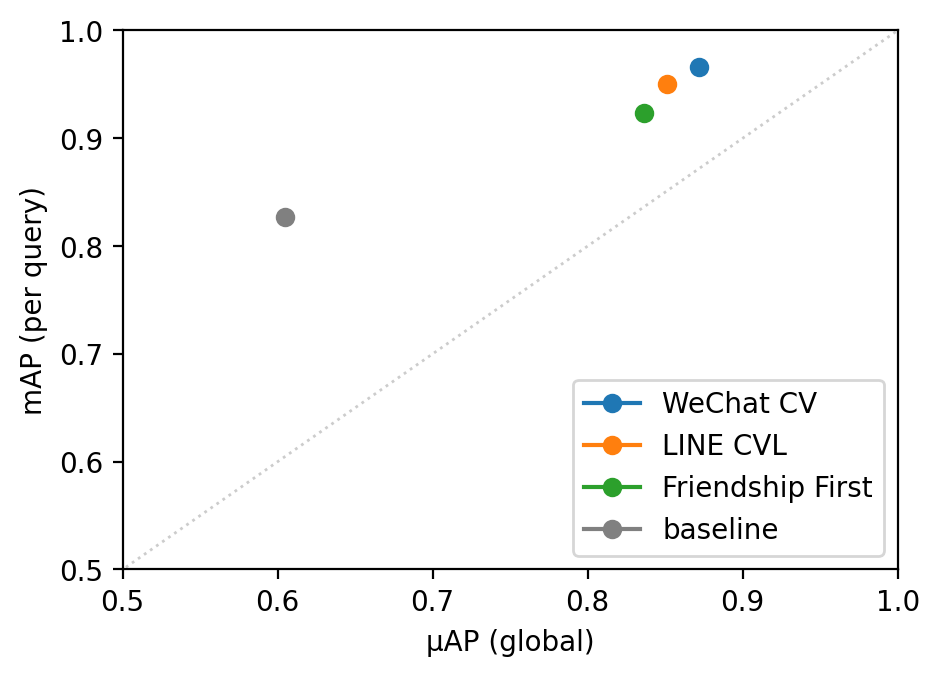

In [428]:
pal = sns.color_palette()
fig, ax = plt.subplots(figsize=(5, 3.5))
for i, name, color in zip(team_order, team_names, team_colors):
    uAP = descriptor_track_aps[i].ap
    mAP = descriptor_maps[i]
    ax.plot(uAP, mAP, color=color, label=name, marker="o")
ax.plot([0, 1], [0, 1], linewidth=1, linestyle=":", color="#cccccc")
ax.set_ylim(.5, 1)
ax.set_xlim(.5, 1)
ax.set_xlabel("μAP (global)")
ax.set_ylabel("mAP (per query)")
ax.legend(loc="lower right")
save_fig("map-comparison")